### Previsão de Mortes Neonatal

Neste projeto, vamos utilizar dados públicos do SINASC (Sistema de Nascidos Vivos) e do SIM (Sistema de Mortalidade) para construir modelos de aprendizado de máquina capazes de prever o risco de morte neonatal (até 28 dias após o nascimento).

*Alunos:*
- Júlia Moraes
- Luiz Eduardo

#### Imports necessários para o projeto

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.model_selection import train_test_split
import seaborn as sns

#### 1.Datasets

##### 1.1 SINASC - Sistema de Nascidos Vivos 

Iniciaremos fazendo o tratamento e limpeza nos dados do SINAC, que adquirimos no site do Ministério da Saúde.

O Governo disponibiliza o [Dicionário de Dados](https://diaad.s3.sa-east-1.amazonaws.com/sinasc/SINASC+-+Estrutura.pdf) referente ao arquivo .csv utilizado. No entanto, neste trabalho serão abordados apenas os campos relevantes para o desenvolvimento do projeto.


##### Variáveis úteis para antes do parto

- Idade da Mãe (IDADEMAE): extremos de idade tais como adolescentes e mulheres mais velhas que 40 anos apresentam mais risco por fatores biológicos
- Número de consultas pré-natais (CONSULTAS): menos consultas significa mais risco de problemas não detectados
- Início pré-natal (MESPRENAT): início tardio pode significar mais risco de problemas não detectados
- Paridade (PARIDADE): primíparas e multíparas com histórico de perdas podem ter riscos diferentes
- Gravidez múltipla (GRAVIDEZ): gêmeos/trigêmeos têm maior risco de prematuridade e baixo peso.

##### Variáveis no nascimento
- Peso ao nascer (PESO): peso baixo ao nascer são fortes preditores de mortalidade
- Idade Gestacional (SEMAGESTAC): principal determinante
- Apgar 1 e 5 minutos (APGAR1, APGAR5): medida imediata da condição neonatal, baixo Apgar indica sofrimento perinatal e forte preditor nos primeiros dias
- Anomalias congênitas (IDANOMAL): se possuir pode aumentar o risco de morte neonatal
- Tipo de parto (PARTO): parto de emergência muitas vezes reflete complicação fetal/materna
- Índice de Kotelchuck ( KOTELCHUCK): avaliação da assistência pré-natal

In [ ]:
sinasc = pd.read_csv("G:\\Meu Drive\\datasets\\SINASC_2023.csv", sep=";")

C:\Users\julja\AppData\Local\Temp\ipykernel_14888\2010564385.py:1: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  sinasc = pd.read_csv("G:\\Meu Drive\\datasets\\SINASC_2023.csv", sep=";")


In [4]:
# ver as primeiras 5 linhas 
sinasc.head()

,contador,ORIGEM,CODESTAB,CODMUNNASC,LOCNASC,IDADEMAE,ESTCIVMAE,ESCMAE,CODOCUPMAE,QTDFILVIVO,...,TPFUNCRESP,TPDOCRESP,DTDECLARAC,ESCMAEAGR1,STDNEPIDEM,STDNNOVA,CODPAISRES,TPROBSON,PARIDADE,KOTELCHUCK
0,1,1,2679477.0,110001,1,32.0,2.0,4.0,999992.0,3.0,...,2.0,3.0,2012023.0,6.0,0.0,1,1.0,3,1,5
1,2,1,2679477.0,110001,1,18.0,1.0,4.0,999992.0,NaN,...,2.0,3.0,25012023.0,6.0,0.0,1,1.0,10,0,5
2,3,1,2679477.0,110001,1,15.0,5.0,3.0,999992.0,0.0,...,2.0,3.0,10022023.0,3.0,0.0,1,1.0,6,0,3
3,4,1,2516500.0,110001,1,32.0,2.0,3.0,999992.0,1.0,...,2.0,3.0,18012023.0,3.0,0.0,1,1.0,5,1,5
4,5,1,2516500.0,110001,1,27.0,1.0,5.0,999991.0,0.0,...,2.0,3.0,18012023.0,8.0,0.0,1,1.0,1,0,5


In [5]:
# quantidade de linhas e colunas
sinasc.shape

(2537576, 62)

In [6]:
# informações gerais
sinasc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2537576 entries, 0 to 2537575
Data columns (total 62 columns):
 #   Column      Dtype  
---  ------      -----  
 0   contador    int64  
 1   ORIGEM      int64  
 2   CODESTAB    float64
 3   CODMUNNASC  int64  
 4   LOCNASC     int64  
 5   IDADEMAE    float64
 6   ESTCIVMAE   float64
 7   ESCMAE      float64
 8   CODOCUPMAE  float64
 9   QTDFILVIVO  float64
 10  QTDFILMORT  float64
 11  CODMUNRES   int64  
 12  GESTACAO    float64
 13  GRAVIDEZ    float64
 14  PARTO       float64
 15  CONSULTAS   float64
 16  DTNASC      int64  
 17  HORANASC    float64
 18  SEXO        int64  
 19  APGAR1      float64
 20  APGAR5      float64
 21  RACACOR     float64
 22  PESO        float64
 23  IDANOMAL    float64
 24  DTCADASTRO  int64  
 25  CODANOMAL   object 
 26  NUMEROLOTE  float64
 27  VERSAOSIST  object 
 28  DTRECEBIM   float64
 29  DIFDATA     int64  
 30  OPORT_DN    int64  
 31  DTRECORIGA  int64  
 32  NATURALMAE  float64
 33  CODMUNN

In [7]:
# estatísticas descritivas
sinasc.describe(include="all")

,contador,ORIGEM,CODESTAB,CODMUNNASC,LOCNASC,IDADEMAE,ESTCIVMAE,ESCMAE,CODOCUPMAE,QTDFILVIVO,...,TPFUNCRESP,TPDOCRESP,DTDECLARAC,ESCMAEAGR1,STDNEPIDEM,STDNNOVA,CODPAISRES,TPROBSON,PARIDADE,KOTELCHUCK
count,2.537576e+06,2.537576e+06,2.512801e+06,2.537576e+06,2.537576e+06,2.537553e+06,2.527680e+06,2.527838e+06,2.356750e+06,2.500450e+06,...,2.474101e+06,2.527016e+06,2.513036e+06,2.517499e+06,2.537573e+06,2.537576e+06,2537555.0,2.537576e+06,2.537576e+06,2.537576e+06
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.268788e+06,1.000139e+00,2.994136e+06,3.202480e+05,1.030377e+00,2.765736e+01,2.006280e+00,4.122294e+00,6.898684e+05,1.027298e+00,...,2.856320e+00,3.220967e+00,1.578357e+07,6.347344e+00,6.774816e-01,9.999882e-01,1.0,4.155663e+00,6.351045e-01,4.473895e+00
std,7.325352e+05,1.179364e-02,1.999851e+06,1.006997e+05,2.624615e-01,6.724978e+00,1.451708e+00,6.814163e-01,3.058799e+05,1.352322e+00,...,1.424529e+00,1.033406e+00,8.776789e+06,2.339970e+00,4.674402e-01,3.438338e-03,0.0,2.698849e+00,4.814009e-01,1.398146e+00
min,1.000000e+00,1.000000e+00,9.400000e+01,1.100010e+05,1.000000e+00,8.000000e+00,1.000000e+00,1.000000e+00,1.020500e+04,0.000000e+00,...,0.000000e+00,0.000000e+00,1.012023e+06,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.000000e+00,0.000000e+00,1.000000e+00
25%,6.343948e+05,1.000000e+00,2.119528e+06,2.601200e+05,1.000000e+00,2.200000e+01,1.000000e+00,4.000000e+00,4.132050e+05,0.000000e+00,...,2.000000e+00,3.000000e+00,8.082023e+06,5.000000e+00,0.000000e+00,1.000000e+00,1.0,2.000000e+00,0.000000e+00,4.000000e+00
50%,1.268788e+06,1.000000e+00,2.461005e+06,3.205300e+05,1.000000e+00,2.700000e+01,1.000000e+00,4.000000e+00,6.220200e+05,1.000000e+00,...,2.000000e+00,3.000000e+00,1.602202e+07,6.000000e+00,1.000000e+00,1.000000e+00,1.0,4.000000e+00,1.000000e+00,5.000000e+00
75%,1.903182e+06,1.000000e+00,2.798220e+06,3.550300e+05,1.000000e+00,3.300000e+01,2.000000e+00,4.000000e+00,9.999920e+05,2.000000e+00,...,5.000000e+00,4.000000e+00,2.310202e+07,8.000000e+00,1.000000e+00,1.000000e+00,1.0,5.000000e+00,1.000000e+00,5.000000e+00


In [8]:
# verificando porcentagem de valores nulos
sinasc.isnull().mean() * 100

contador      0.000000
ORIGEM        0.000000
CODESTAB      0.976325
CODMUNNASC    0.000000
LOCNASC       0.000000
                ...   
STDNNOVA      0.000000
CODPAISRES    0.000828
TPROBSON      0.000000
PARIDADE      0.000000
KOTELCHUCK    0.000000
Length: 62, dtype: float64

In [9]:
# verificando os tipos de dados de cada coluna
for coluna, tipo in sinasc.dtypes.items():
    print(f"{coluna}: {tipo}")

contador: int64
ORIGEM: int64
CODESTAB: float64
CODMUNNASC: int64
LOCNASC: int64
IDADEMAE: float64
ESTCIVMAE: float64
ESCMAE: float64
CODOCUPMAE: float64
QTDFILVIVO: float64
QTDFILMORT: float64
CODMUNRES: int64
GESTACAO: float64
GRAVIDEZ: float64
PARTO: float64
CONSULTAS: float64
DTNASC: int64
HORANASC: float64
SEXO: int64
APGAR1: float64
APGAR5: float64
RACACOR: float64
PESO: float64
IDANOMAL: float64
DTCADASTRO: int64
CODANOMAL: object
NUMEROLOTE: float64
VERSAOSIST: object
DTRECEBIM: float64
DIFDATA: int64
OPORT_DN: int64
DTRECORIGA: int64
NATURALMAE: float64
CODMUNNATU: float64
CODUFNATU: object
ESCMAE2010: float64
SERIESCMAE: float64
DTNASCMAE: float64
RACACORMAE: float64
QTDGESTANT: float64
QTDPARTNOR: float64
QTDPARTCES: float64
IDADEPAI: float64
DTULTMENST: float64
SEMAGESTAC: float64
TPMETESTIM: float64
CONSPRENAT: float64
MESPRENAT: float64
TPAPRESENT: float64
STTRABPART: float64
STCESPARTO: float64
TPNASCASSI: float64
TPFUNCRESP: float64
TPDOCRESP: float64
DTDECLARAC: float6

In [10]:
# renomear colunas para facilitar o entendimento
sinasc.rename(columns={
    "IDADEMAE": "idade_mae",
    "CONSULTAS": "consultas_prenatal",
    "MESPRENAT": "mes_inicio_prenatal",
    "PARIDADE": "paridade",
    "GRAVIDEZ": "tipo_gravidez",
    "PESO": "peso_bebe",
    "SEMAGESTAC": "semanas_gestacao",
    "APGAR1": "apgar_1min",
    "APGAR5": "apgar_5min",
    "IDANOMAL": "anomalia_identificada",
    "PARTO": "tipo_parto",
    "KOTELCHUCK": "indice_kotelchuck",
    "ESCMAE": "escolaridade_mae"
}, inplace=True)

In [11]:
# remover linhas duplicadas
sinasc.drop_duplicates(inplace=True)

Criação de variáveis clinicamente relevantes para a predição 

In [12]:
# Baixo peso e muito baixo peso
sinasc["baixo_peso"] = (sinasc["peso_bebe"] < 2500).astype(int)
sinasc["muito_baixo_peso"] = (sinasc["peso_bebe"] < 1500).astype(int)

In [13]:
# Prematuro ou prematuro extremo
sinasc["prematuro"] = (sinasc["semanas_gestacao"] < 37).astype(int)
sinasc["prematuro_extremo"] = (sinasc["semanas_gestacao"] < 28).astype(int)

In [14]:
# Apgar crítico ou baixo
sinasc['apgar5_baixo'] = (sinasc['apgar_5min'] < 7).astype(int)
sinasc['apgar1_critico'] = (sinasc['apgar_1min'] < 4).astype(int)

# Apgar sem melhoria entre o 1 e 5 minutos
sinasc['apgar_sem_melhoria'] = ((sinasc['apgar_5min'] - sinasc['apgar_1min']) <= 2).astype(int)

In [15]:
#Idades da mãe
sinasc['mae_adolescente'] = (sinasc['idade_mae'] < 18).astype(int)
sinasc['mae_idade_avancada'] = (sinasc['idade_mae'] > 35).astype(int)

In [16]:
#Pré natal inadequado
sinasc['prenatal_inadequado'] = sinasc['indice_kotelchuck'].isin([1, 2]).astype(int)
sinasc['poucas_consultas'] = (sinasc['consultas_prenatal'] < 4).astype(int)
sinasc['prenatal_tardio'] = (sinasc['mes_inicio_prenatal'] > 3).astype(int)

In [17]:
# Variáveis compostas
sinasc['risco_extremo'] = ((sinasc['prematuro_extremo'] == 1) & (sinasc['muito_baixo_peso'] == 1)).astype(int)
    
sinasc['escore_risco_neonatal'] = (
    (sinasc['baixo_peso'] == 1) +
        (sinasc['prematuro'] == 1) + 
        (sinasc['apgar5_baixo'] == 1) +
        (sinasc['anomalia_identificada'] == 1)
    )

sinasc['risco_materno'] = (
    (sinasc['mae_adolescente'] == 1) +
    (sinasc['mae_idade_avancada'] == 1) +
    (sinasc['prenatal_inadequado'] == 1)
    )

##### 1.2 SIM (Sistema de mortalidade)

In [21]:
sim = pd.read_csv("G:\\Meu Drive\\datasets\\DO23OPEN.csv", sep=";")

C:\Users\julja\AppData\Local\Temp\ipykernel_14888\1463452491.py:1: DtypeWarning: Columns (65) have mixed types. Specify dtype option on import or set low_memory=False.
  sim = pd.read_csv("G:\\Meu Drive\\datasets\\DO23OPEN.csv", sep=";")


In [23]:
sinasc.rename(columns={
    'DTNASC': 'data_nasc',
    'SEXO': 'sexo',
    'CODMUNNASC': 'codmun_res',
    'DTCADASTRO': 'dt_cadastro',
}, inplace=True)

sim.rename(columns={
    'DTOBITO': 'data_obito', 
    'SEXO': 'sexo',
    'CODMUNRES': 'codmun_res',
    'IDADEMAE': 'idade_mae',
    'DTCADASTRO': 'dt_cadastro',
    'DTNASC': 'data_nasc'
}, inplace=True)


In [24]:
#deixando apenas os obitos que ocorreram em 1 mês de vida
sim = sim[sim['IDADE'] < 302]

In [25]:
sim.head()

,contador,ORIGEM,TIPOBITO,data_obito,HORAOBITO,NATURAL,CODMUNNATU,data_nasc,IDADE,sexo,...,TPRESGINFO,TPNIVELINV,DTCADINF,MORTEPARTO,DTCONCASO,ALTCAUSA,CAUSABAS_O,TPPOS,TP_ALTERA,CB_ALT
34,35,1,2,1012023,2150.0,835.0,350400.0,17122022.0,215,1,...,NaN,NaN,2022023.0,3.0,2022023.0,2.0,Q248,S,NaN,NaN
242,243,1,2,1012023,2030.0,823.0,230190.0,1012023.0,105,1,...,NaN,NaN,1032023.0,3.0,5012023.0,2.0,P228,S,NaN,NaN
413,414,1,2,1012023,624.0,835.0,355700.0,30122022.0,201,1,...,NaN,NaN,15022023.0,3.0,9022023.0,2.0,P369,S,NaN,NaN
428,429,1,2,1012023,2300.0,851.0,510760.0,14122022.0,218,2,...,NaN,NaN,20022024.0,9.0,NaN,NaN,Q042,N,NaN,NaN
450,451,1,2,1012023,120.0,841.0,411840.0,31122022.0,201,1,...,NaN,NaN,25032023.0,3.0,25032023.0,1.0,P072,S,NaN,NaN


In [26]:
sim.shape

(25094, 86)

##### Matchs para encontrar os óbitos

In [27]:
#pegando os casos que estão nos dois datasets
matches = pd.merge(
    sinasc,
    sim,
    left_on=['sexo', 'codmun_res', 'idade_mae', 'data_nasc', 'RACACOR'],
    right_on=['sexo', 'codmun_res', 'idade_mae', 'data_nasc', 'RACACOR'],
    suffixes=('_sinasc', '_sim')
)

In [28]:
matches.shape

(14986, 158)

In [29]:
matches.head()

,contador_sinasc,ORIGEM_sinasc,CODESTAB_sinasc,codmun_res,LOCNASC,idade_mae,ESTCIVMAE,escolaridade_mae,CODOCUPMAE,QTDFILVIVO_sinasc,...,TPRESGINFO,TPNIVELINV,DTCADINF,MORTEPARTO,DTCONCASO,ALTCAUSA,CAUSABAS_O,TPPOS,TP_ALTERA,CB_ALT
0,29,1,2494299.0,110002,1,26.0,4.0,4.0,354705.0,0.0,...,NaN,NaN,15022023.0,3.0,15022023.0,2.0,P000,S,NaN,NaN
1,441,1,2494299.0,110002,1,33.0,4.0,4.0,512105.0,2.0,...,NaN,NaN,6062023.0,9.0,NaN,NaN,Q249,N,NaN,NaN
2,1723,1,2496046.0,110004,1,24.0,2.0,4.0,999992.0,0.0,...,NaN,NaN,14062023.0,9.0,NaN,NaN,Q000,S,NaN,NaN
3,2338,1,3049450.0,110009,1,25.0,1.0,4.0,621005.0,1.0,...,NaN,NaN,24042023.0,3.0,24042023.0,2.0,P363,NaN,NaN,NaN
4,2591,1,2515768.0,110010,1,28.0,1.0,4.0,999992.0,1.0,...,NaN,NaN,15052023.0,3.0,15052023.0,2.0,Q878,N,NaN,NaN


In [30]:
matches['contador'] = range(len(matches))

In [31]:
matches['contador']

0            0
1            1
2            2
3            3
4            4
         ...  
14981    14981
14982    14982
14983    14983
14984    14984
14985    14985
Name: contador, Length: 14986, dtype: int64

Limpando o novo dataset

In [32]:
matches.drop(columns=['contador_sinasc', 'contador_sim'], inplace=True)

In [33]:
matches.drop(columns=['ORIGEM_sinasc', 'ORIGEM_sim', 'DIFDATA_sinasc', 'DIFDATA_sim'], inplace=True)
matches.drop(columns=['ESC2010', 'SERIESCFAL', 'OCUP', 'ESC'], inplace=True)

In [34]:
matches.head()

,CODESTAB_sinasc,codmun_res,LOCNASC,idade_mae,ESTCIVMAE,escolaridade_mae,CODOCUPMAE,QTDFILVIVO_sinasc,QTDFILMORT_sinasc,CODMUNRES,...,TPNIVELINV,DTCADINF,MORTEPARTO,DTCONCASO,ALTCAUSA,CAUSABAS_O,TPPOS,TP_ALTERA,CB_ALT,contador
0,2494299.0,110002,1,26.0,4.0,4.0,354705.0,0.0,0.0,110002,...,NaN,15022023.0,3.0,15022023.0,2.0,P000,S,NaN,NaN,0
1,2494299.0,110002,1,33.0,4.0,4.0,512105.0,2.0,1.0,110002,...,NaN,6062023.0,9.0,NaN,NaN,Q249,N,NaN,NaN,1
2,2496046.0,110004,1,24.0,2.0,4.0,999992.0,0.0,0.0,110004,...,NaN,14062023.0,9.0,NaN,NaN,Q000,S,NaN,NaN,2
3,3049450.0,110009,1,25.0,1.0,4.0,621005.0,1.0,0.0,110009,...,NaN,24042023.0,3.0,24042023.0,2.0,P363,NaN,NaN,NaN,3
4,2515768.0,110010,1,28.0,1.0,4.0,999992.0,1.0,2.0,110010,...,NaN,15052023.0,3.0,15052023.0,2.0,Q878,N,NaN,NaN,4


In [35]:
print(matches.isnull().sum())

CODESTAB_sinasc      325
codmun_res             0
LOCNASC                0
idade_mae              0
ESTCIVMAE             38
                   ...  
CAUSABAS_O            11
TPPOS               3988
TP_ALTERA          14937
CB_ALT             14937
contador               0
Length: 149, dtype: int64


In [36]:
limite = 0.4

#remove colunas com mais de 40% de nulos
matches = matches.loc[:, matches.isnull().mean() < limite]

In [37]:
matches.head()

,CODESTAB_sinasc,codmun_res,LOCNASC,idade_mae,ESTCIVMAE,escolaridade_mae,CODOCUPMAE,QTDFILVIVO_sinasc,QTDFILMORT_sinasc,CODMUNRES,...,STDOEPIDEM,STDONOVA,FONTES,DTCADINF,MORTEPARTO,DTCONCASO,ALTCAUSA,CAUSABAS_O,TPPOS,contador
0,2494299.0,110002,1,26.0,4.0,4.0,354705.0,0.0,0.0,110002,...,0.0,1,SXSSXX,15022023.0,3.0,15022023.0,2.0,P000,S,0
1,2494299.0,110002,1,33.0,4.0,4.0,512105.0,2.0,1.0,110002,...,0.0,1,XXXXXX,6062023.0,9.0,NaN,NaN,Q249,N,1
2,2496046.0,110004,1,24.0,2.0,4.0,999992.0,0.0,0.0,110004,...,0.0,1,XXXXXX,14062023.0,9.0,NaN,NaN,Q000,S,2
3,3049450.0,110009,1,25.0,1.0,4.0,621005.0,1.0,0.0,110009,...,0.0,1,SXSSXX,24042023.0,3.0,24042023.0,2.0,P363,NaN,3
4,2515768.0,110010,1,28.0,1.0,4.0,999992.0,1.0,2.0,110010,...,0.0,1,XXSXXX,15052023.0,3.0,15052023.0,2.0,Q878,N,4


Criando em SINASC uma coluna óbitos

In [39]:
#inicia coluna com 0
sinasc['obitos_1m'] = 0

In [40]:
#marca os que tiveram óbito em 1 mês
sinasc.loc[matches.index, 'obitos_1m'] = 1

In [53]:
sinasc['obitos_1m'].value_counts()

obitos_1m
0    2522590
1      14986
Name: count, dtype: int64

In [50]:
# Seleciona todas as linhas com óbito = 1
obitos_1 = sinasc[sinasc['obitos_1m'] == 1]

# Seleciona o dobro de linhas com óbito = 0 (amostragem aleatória)
n_dobro = 2 * len(obitos_1)
obitos_0 = sinasc[sinasc['obitos_1m'] == 0].sample(n=n_dobro, random_state=42)

# Junta os dois DataFrames
sinasc_balanceado = pd.concat([obitos_1, obitos_0])

In [91]:
sinasc_balanceado['obitos_1m'].value_counts()

obitos_1m
0    29972
1    14986
Name: count, dtype: int64

In [117]:
colunas_para_dropar = [
    # Identificadores / controle
    'contador', 'NUMEROLOTE', 'VERSAOSIST', 'OPORT_DN', 'CODANOMAL', 'ORIGEM',
    # Datas irrelevantes
    'data_nasc', 'HORANASC', 'dt_cadastro', 'DTRECEBIM', 'DIFDATA',
    'DTRECORIGA', 'DTDECLARAC', 'DTULTMENST',
]

dataset_limpo = sinasc_balanceado.drop(columns=colunas_para_dropar)

# Salvar o dataset limpo
dataset_limpo.to_csv("sinasc_balanceado.csv", index=False)

#### 2. Análise Exploratória dos dados

In [118]:
dataset = pd.read_csv("SINASC_balanceado.csv")

Quantos sobreviveram x Quantos morreram

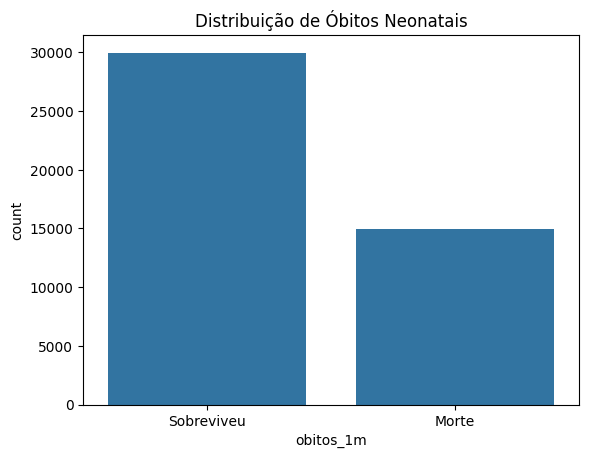

In [101]:
sns.countplot(x='obitos_1m', data=dataset)
plt.xticks([0,1], ['Sobreviveu','Morte'])
plt.title('Distribuição de Óbitos Neonatais')
plt.show()

Peso x Óbito

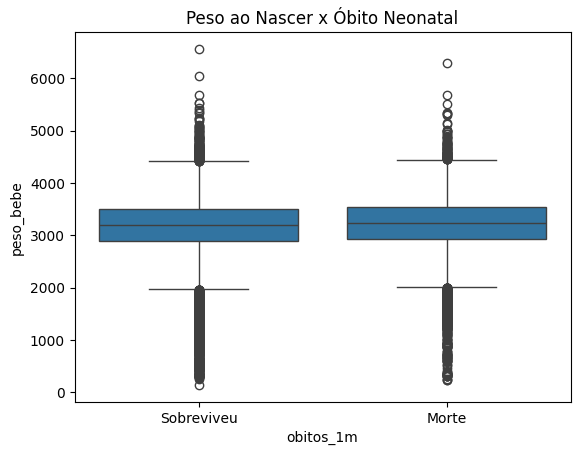

In [102]:
sns.boxplot(x='obitos_1m', y='peso_bebe', data=dataset)
plt.xticks([0,1], ['Sobreviveu','Morte'])
plt.title('Peso ao Nascer x Óbito Neonatal')
plt.show()

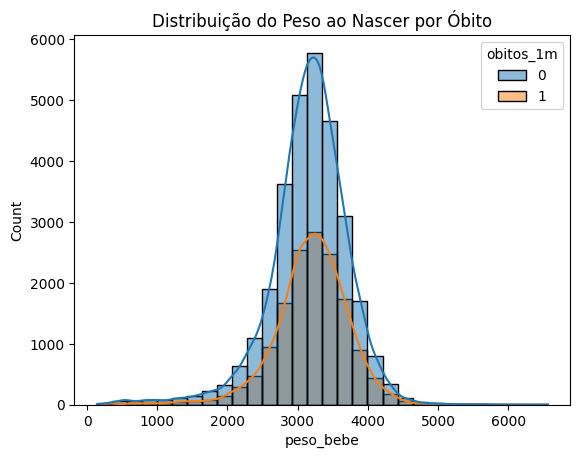

In [103]:
sns.histplot(data=dataset, x='peso_bebe', hue='obitos_1m', kde=True, bins=30)
plt.title('Distribuição do Peso ao Nascer por Óbito')
plt.show()

Prematuro x Óbito

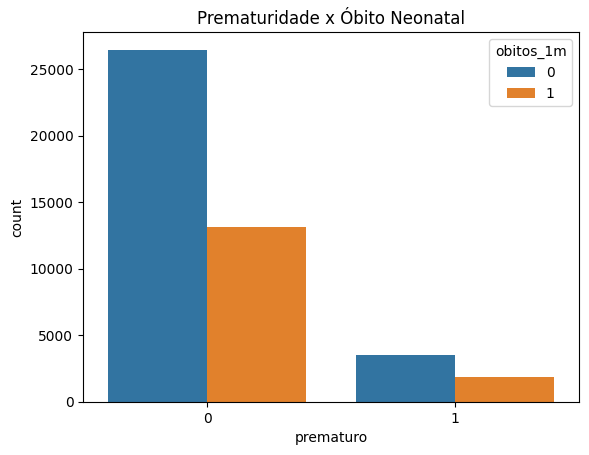

In [104]:
sns.countplot(x='prematuro', hue='obitos_1m', data=dataset)
plt.title('Prematuridade x Óbito Neonatal')
plt.show()

Apgar x Óbito

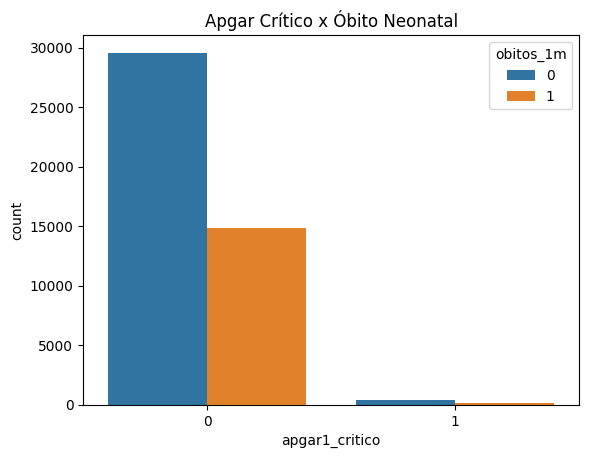

In [105]:
sns.countplot(x='apgar1_critico', hue='obitos_1m', data=dataset)
plt.title('Apgar Crítico x Óbito Neonatal')
plt.show()

Idade Materna x Óbito

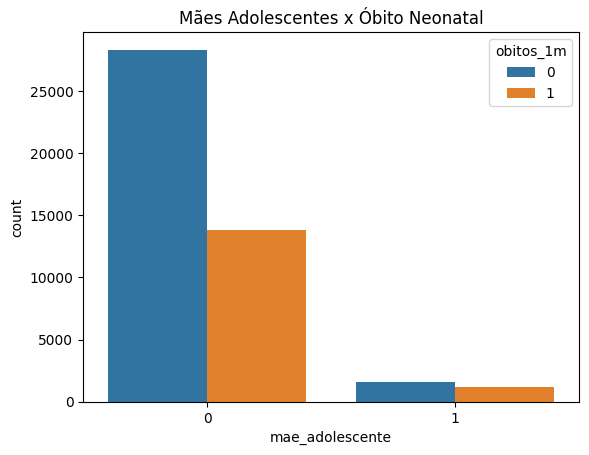

In [106]:
sns.countplot(x='mae_adolescente', hue='obitos_1m', data=dataset)
plt.title('Mães Adolescentes x Óbito Neonatal')
plt.show()

Impacto Pré-Natal x Óbito

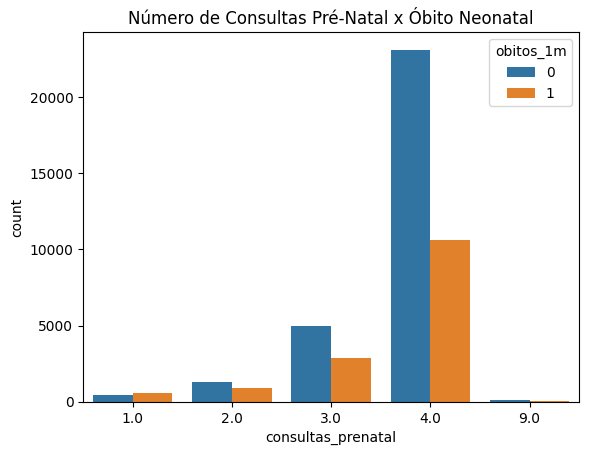

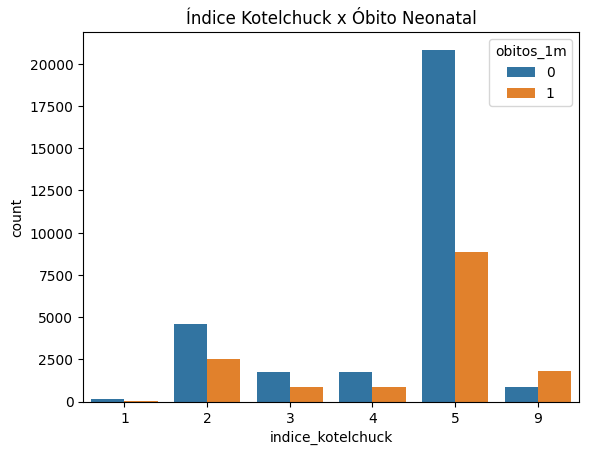

In [107]:
sns.countplot(x='consultas_prenatal', hue='obitos_1m', data=dataset)
plt.title('Número de Consultas Pré-Natal x Óbito Neonatal')
plt.show()

sns.countplot(x='indice_kotelchuck', hue='obitos_1m', data=dataset)
plt.title('Índice Kotelchuck x Óbito Neonatal')
plt.show()

Tipo de Parto x Óbito

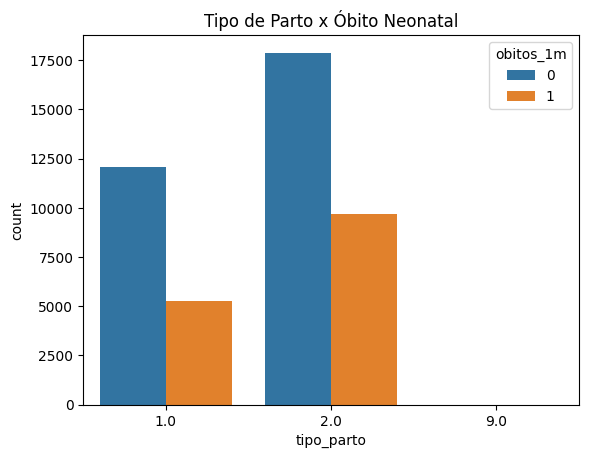

In [108]:
sns.countplot(x='tipo_parto', hue='obitos_1m', data=dataset)
plt.title('Tipo de Parto x Óbito Neonatal')
plt.show()

Escore de risco x Óbito

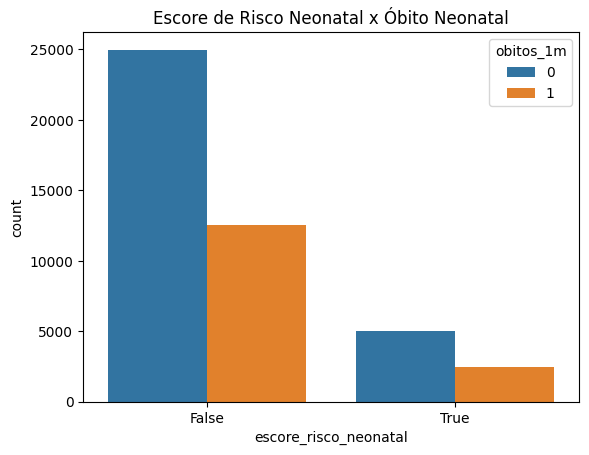

In [109]:
sns.countplot(x='escore_risco_neonatal', hue='obitos_1m', data=dataset)
plt.title('Escore de Risco Neonatal x Óbito Neonatal')
plt.show()

Matriz de Calor

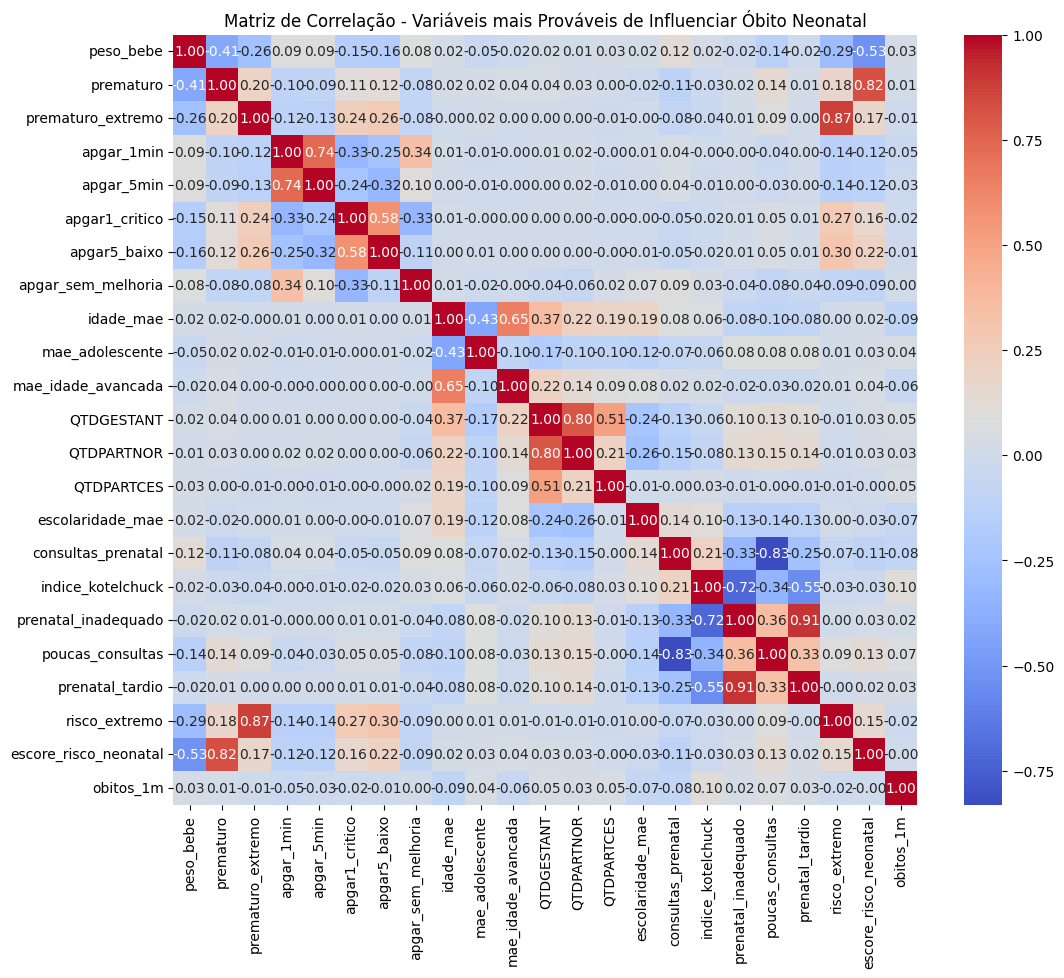

In [110]:
variaveis = [
    'peso_bebe', 'prematuro', 'prematuro_extremo',
    'apgar_1min', 'apgar_5min', 'apgar1_critico', 'apgar5_baixo', 'apgar_sem_melhoria',
    'idade_mae', 'mae_adolescente', 'mae_idade_avancada',
    'QTDGESTANT', 'QTDPARTNOR', 'QTDPARTCES',
    'escolaridade_mae', 'consultas_prenatal', 'indice_kotelchuck',
    'prenatal_inadequado', 'poucas_consultas', 'prenatal_tardio',
    'risco_extremo', 'escore_risco_neonatal', 'obitos_1m'
]

df_corr = dataset[variaveis]

# Matriz de correlação
corr = df_corr.corr()

# Plotar heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de Correlação - Variáveis mais Prováveis de Influenciar Óbito Neonatal")
plt.show()


#### 3. Tratamento de dados básico

##### 3.1 Construindo matriz X e vetor y

In [119]:
y = dataset['obitos_1m']
X = dataset.drop(columns=['obitos_1m'])

##### 3.2 Número de amostras (𝑁) e número de parâmetros (𝑝)

In [120]:
N, p = X.shape

print(f"Número de amostras (N): {N}")
print(f"Número de parâmetros (p): {p}")

Número de amostras (N): 44958
Número de parâmetros (p): 63


##### 3.3 Separar os dados em treino e teste

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)  

##### 3.4 Separar os dados de treino em treino e validaçao

In [122]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

##### 3.5 Aplicar normalização ou padronização dos dados